Copyright (c) 2025 Graphcore Ltd. All rights reserved.

# Data Analysis and Paper Figures

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

sns.set_theme()

In [2]:
# Load KG topology metrics (generated with compute_topology_metrics.ipynb)

data_path = Path("../datasets/data/")
ds_name_dir = {
    "Hetionet": "hetionet",
    "OpenBioLink": "openbiolink",
    "PharMeBINet": "pharmebinet",
    "PharmKG": "pharmkg",
    "PrimeKG": "primekg",
    "FB15k-237": "fb15k-237",
}

node_dict = {
    n: pd.read_pickle(data_path.joinpath(f"{d}/node_graph_metrics.pkl"))[
        "node_degree_summary"
    ]
    for n, d in ds_name_dir.items()
}
dcs_dict = {
    n: pd.read_pickle(data_path.joinpath(f"{d}/edge_graph_metrics.pkl"))[
        "edge_degree_cardinality_summary"
    ].drop_duplicates(["h", "r", "t"])
    for n, d in ds_name_dir.items()
}
eps_dict = {
    n: pd.read_pickle(data_path.joinpath(f"{d}/edge_graph_metrics.pkl"))[
        "edge_pattern_summary"
    ].drop_duplicates(["h", "r", "t"])
    for n, d in ds_name_dir.items()
}

rel_dict = {
    n: pickle.load(open(data_path.joinpath(f"{d}/relation_dict.pkl"), "rb"))
    for n, d in ds_name_dir.items()
}

In [ ]:
# Load ranks of model predictions ranks (rank of ground truth tail in the list of KG entities sorted by likelihood)

kge_ranks = {
    graph: pd.read_csv(f"../datasets/{graph}/test_ranks.csv")
    for graph in ds_name_dir.keys()
}

## KG Topological statistics

In [238]:
df_cardinality_count = []
for graph in ds_name_dir.keys():
    df_tmp = pd.merge(kge_ranks[graph], dcs_dict[graph], how="left", on=["h", "r", "t"])
    df_tmp["graph"] = graph
    df_cardinality_count.append(df_tmp[["graph", "triple_cardinality_same_rel", "h"]])
df_cardinality_count = pd.concat(df_cardinality_count)

In [239]:
df_cardinality_count = df_cardinality_count.groupby(
    ["graph", "triple_cardinality_same_rel"], as_index=False
)["h"].count()
df_cardinality_count["fraction_cardinality"] = df_cardinality_count[
    "h"
] / df_cardinality_count.groupby("graph")["h"].transform(sum)

/tmp/ipykernel_134796/1487937795.py:6: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ] / df_cardinality_count.groupby("graph")["h"].transform(sum)


### Fig. 4: Statistics of edge cardinality types

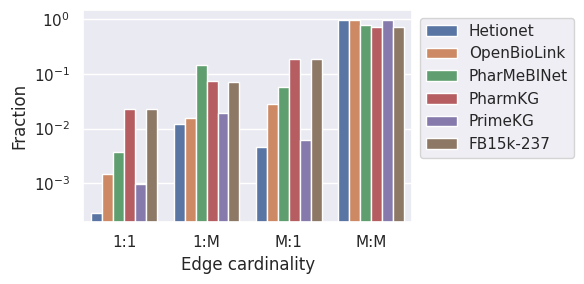

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])

sns.barplot(
    df_cardinality_count,
    x="triple_cardinality_same_rel",
    y="fraction_cardinality",
    hue="graph",
    hue_order=[
        "Hetionet",
        "OpenBioLink",
        "PharMeBINet",
        "PharmKG",
        "PrimeKG",
        "FB15k-237",
    ],
    ax=ax,
)
ax.set_yscale("log")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Edge cardinality")
ax.set_ylabel("Fraction")

plt.tight_layout()

### Fig. 5 (and S1): frequency of (head out-degree, tail in-degree)

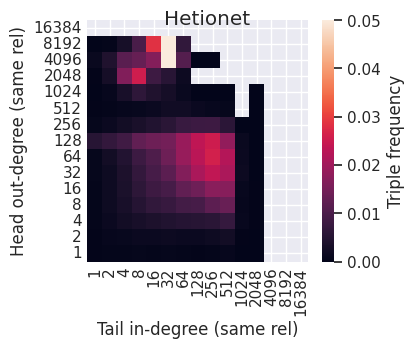

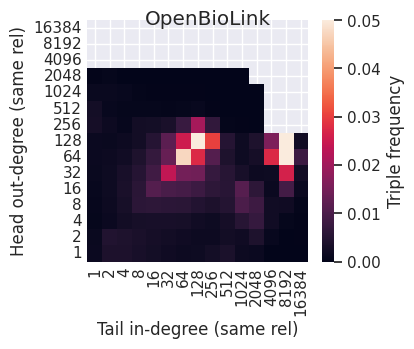

In [ ]:
group_metric_1 = "h_degree_same_rel"
group_metric_2 = "t_degree_same_rel"

name_mapping = {
    "h_degree_same_rel": "Head out-degree (same rel)",
    "t_degree_same_rel": "Tail in-degree (same rel)",
}

for graph in ["Hetionet", "OpenBioLink"]:
    df_empty = pd.DataFrame(
        columns=np.int32(2 ** np.arange(15)), index=np.int32(2 ** np.arange(15))
    )

    fig, ax = plt.subplots(1, 1, figsize=[4, 3.5], squeeze=False)
    df_tmp = dcs_dict[graph][["h", group_metric_1, group_metric_2]]
    df_tmp.insert(
        0,
        f"log_{group_metric_1}",
        np.int32(2 ** np.floor(np.log2(df_tmp[group_metric_1]))),
    )
    df_tmp.insert(
        0,
        f"log_{group_metric_2}",
        np.int32(2 ** np.floor(np.log2(df_tmp[group_metric_2]))),
    )
    df_tmp = (
        df_tmp.groupby([f"log_{group_metric_1}", f"log_{group_metric_2}"])
        .count()
        .reset_index()
    )
    df_tmp["h"] /= df_tmp["h"].sum()
    sns.heatmap(
        df_tmp.reset_index()
        .pivot(
            columns=f"log_{group_metric_2}",
            index=f"log_{group_metric_1}",
            values="h",
        )
        .combine_first(df_empty),
        annot=False,
        vmin=0,
        vmax=0.05,
        ax=ax[0, 0],
        cbar_kws={"label": f"Triple frequency"},
    )
    ax[0, 0].tick_params(axis="both", which="major", pad=-2)
    ax[0, 0].set_xlabel(name_mapping[group_metric_2])
    ax[0, 0].set_ylabel(name_mapping[group_metric_1])
    ax[0, 0].invert_yaxis()
    plt.suptitle(graph)
    plt.subplots_adjust(
        left=0.2,
        bottom=0.26,
        right=0.89,
        top=0.95,
        wspace=0,
        hspace=0,
    )

## Overall prediction metrics

In [23]:
# Compute metrics

graph_list = []
fn_list = []
mrr_list = []
hits_at_1 = []
hits_at_10 = []
for graph in ds_name_dir.keys():
    for scoring_function in ["DistMult", "RotatE", "TransE", "TripleRE", "ConvE"]:
        graph_list.append(graph)
        fn_list.append(scoring_function)
        mrr_list.append(np.mean(1 / kge_ranks[graph][scoring_function].values))
        hits_at_1.append(np.mean(kge_ranks[graph][scoring_function].values <= 1))
        hits_at_10.append(np.mean(kge_ranks[graph][scoring_function].values <= 10))
df_metrics = pd.DataFrame(
    {
        "Graph": graph_list,
        "Scoring Function": fn_list,
        "MRR": mrr_list,
        "Hits@1": hits_at_1,
        "Hits@10": hits_at_10,
    }
)

### Fig. 6: MRR of KGE models

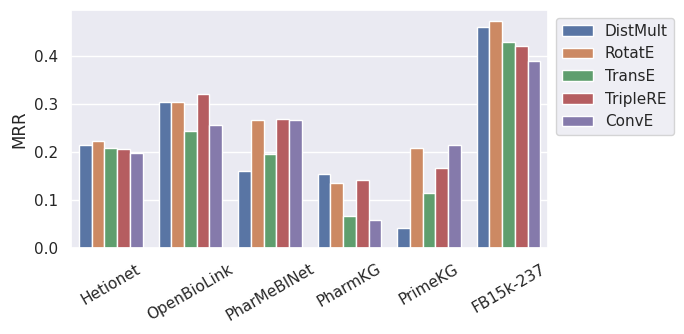

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[7, 3.5])
sns.barplot(
    df_metrics,
    x="Graph",
    y="MRR",
    hue="Scoring Function",
    ax=ax,
    order=["Hetionet", "OpenBioLink", "PharMeBINet", "PharmKG", "PrimeKG", "FB15k-237"],
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.tick_params(axis="x", labelrotation=30)
ax.set_xlabel("")
plt.tight_layout()

### Fig. S2: Hits@1, Hits@10 of KGE models

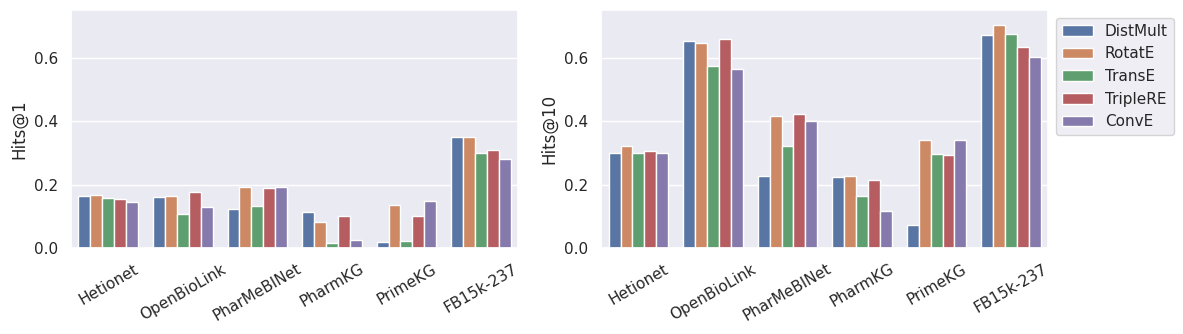

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3.5])

for i, k in enumerate([1, 10]):
    sns.barplot(
        df_metrics,
        x="Graph",
        y=f"Hits@{k}",
        hue="Scoring Function",
        ax=ax[i],
        order=[
            "Hetionet",
            "OpenBioLink",
            "PharMeBINet",
            "PharmKG",
            "PrimeKG",
            "FB15k-237",
        ],
    )
    if i == 1:
        ax[i].legend(loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax[i].get_legend().remove()
    ax[i].tick_params(axis="x", labelrotation=30)
    ax[i].set_xlabel("")
    ax[i].set_ylim([0.0, 0.75])
plt.tight_layout()

## Analysis of predictive performance by edge cardinality

In [ ]:
values = [
    "DistMult",
    "RotatE",
    "TransE",
    "TripleRE",
    "ConvE",
]  # list of KGE models to plot

perf_metric = (
    "MRR"  # change with "Hits@k" to generate figures for Hits@k metrics (specify k)
)

In [9]:
df_mrr_cardinality = pd.DataFrame(
    columns=[
        "graph",
        "r",
        "triple_cardinality_same_rel",
        "h_degree_same_rel",
        "t_degree_same_rel",
    ]
    + values
)

for graph in ds_name_dir.keys():
    df_res = pd.merge(kge_ranks[graph], dcs_dict[graph], how="left", on=["h", "r", "t"])
    df_res = pd.merge(df_res, eps_dict[graph], how="left", on=["h", "r", "t"])
    df_tmp = df_res[
        [
            "r",
            "triple_cardinality_same_rel",
            "h_degree_same_rel",
            "t_degree_same_rel",
            "is_symmetric",
            "has_inverse",
            "has_inference",
            "has_composition",
        ]
    ]
    df_tmp.insert(0, "graph", graph)
    for scoring in values:
        if perf_metric == "MRR":
            df_tmp.insert(0, scoring, 1 / df_res[scoring])
        elif perf_metric[:4] == "Hits":
            df_tmp.insert(
                0, scoring, df_res[scoring] <= int(perf_metric.split("@")[-1])
            )
        else:
            raise ValueError("perf_metric not recognized")
    df_mrr_cardinality = pd.concat([df_mrr_cardinality, df_tmp])
df_mrr_cardinality = df_mrr_cardinality.melt(
    id_vars=[
        "graph",
        "r",
        "triple_cardinality_same_rel",
        "h_degree_same_rel",
        "t_degree_same_rel",
        "is_symmetric",
        "has_inverse",
        "has_inference",
        "has_composition",
    ],
    var_name="scoring_function",
    value_name=perf_metric,
)

/tmp/ipykernel_150133/3880095659.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mrr_cardinality = pd.concat([df_mrr_cardinality, df_tmp])


### Fig. 7 (and S3): predictive performance grouped by edge cardinality

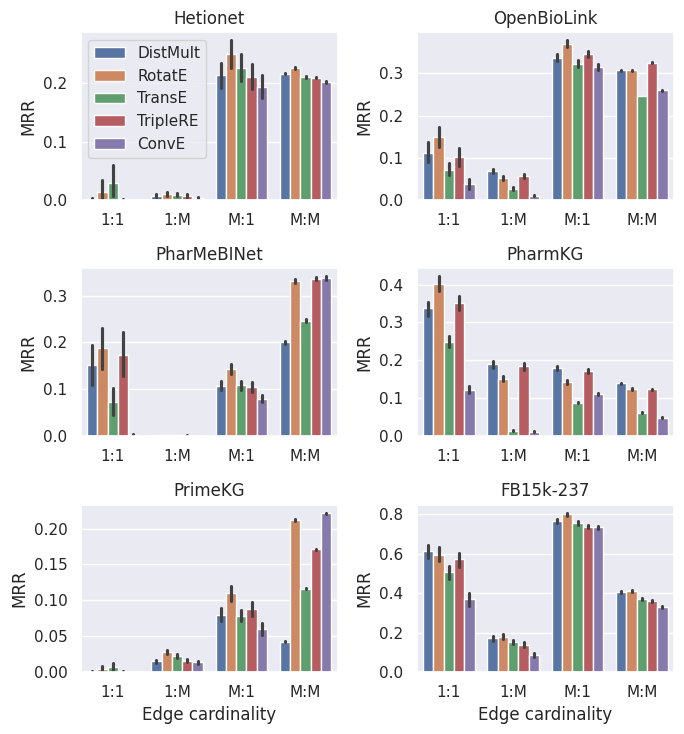

In [ ]:
fig, axn = plt.subplots(3, 2, figsize=[2 * 3.5, 3 * 2.5], sharex=False, sharey=False)

for n, (ax, graph) in enumerate(zip(axn.flat, ds_name_dir.keys())):
    sns.barplot(
        df_mrr_cardinality[df_mrr_cardinality.graph == graph],
        x="triple_cardinality_same_rel",
        y=perf_metric,
        hue="scoring_function",
        order=["1:1", "1:M", "M:1", "M:M"],
        ax=ax,
    )
    ax.set_title(graph)
    leg = ax.get_legend()
    ax.set_xlabel("Edge cardinality")
    if n == 0:
        ax.legend(loc="upper left")
    else:
        leg.remove()
    if n < 4:
        ax.set_xlabel("")

plt.tight_layout()

### Fig. 8 (and S7, S9): predictive performance grouped by (head out-degree, tail in-degree)

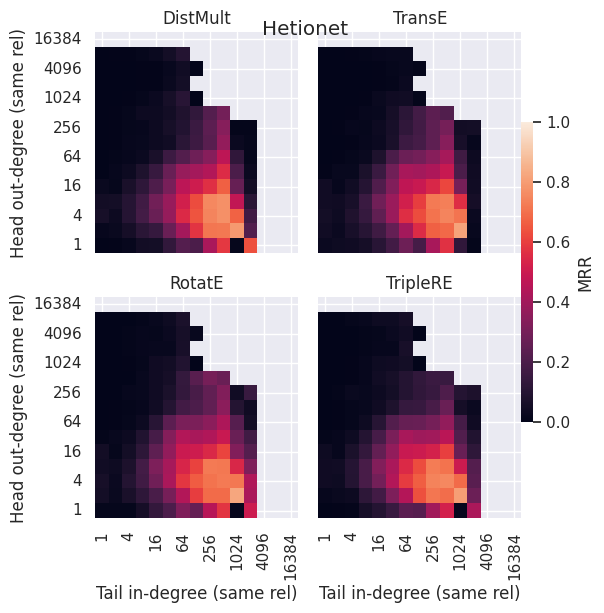

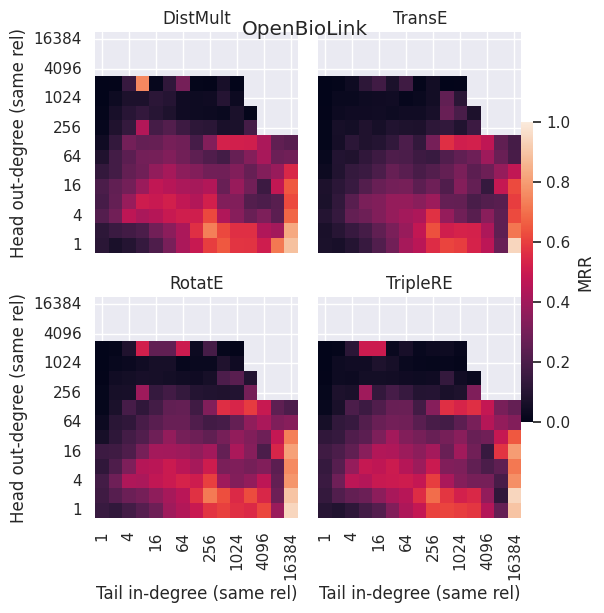

In [ ]:
for graph in ["Hetionet", "OpenBioLink"]:
    df_empty = pd.DataFrame(
        columns=np.int32(2 ** np.arange(15)), index=np.int32(2 ** np.arange(15))
    )

    fig, axn = plt.subplots(2, 2, figsize=[6, 6], sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.86, 0.31, 0.02, 0.5])

    for n, (value, ax) in enumerate(zip(values, axn.T.flat)):
        df_tmp = df_mrr_cardinality[
            np.logical_and(
                df_mrr_cardinality.graph == graph,
                df_mrr_cardinality.scoring_function == value,
            )
        ][[group_metric_1, group_metric_2, perf_metric]]
        df_tmp.insert(
            0,
            f"log_{group_metric_1}",
            np.int32(
                2 ** np.floor(np.log2(df_tmp[group_metric_1].values.astype(np.float32)))
            ),
        )
        df_tmp.insert(
            0,
            f"log_{group_metric_2}",
            np.int32(
                2 ** np.floor(np.log2(df_tmp[group_metric_2].values.astype(np.float32)))
            ),
        )
        df_tmp.insert(0, value, df_tmp[perf_metric].values.astype(np.float32))
        df_tmp = (
            df_tmp.groupby([f"log_{group_metric_1}", f"log_{group_metric_2}"])
            .mean()
            .reset_index()
        )
        sns.heatmap(
            df_tmp.reset_index()
            .pivot(
                columns=f"log_{group_metric_2}",
                index=f"log_{group_metric_1}",
                values=value,
            )
            .combine_first(df_empty),
            vmin=0,
            vmax=1,
            annot=False,
            ax=ax,
            cbar=(n == 0),
            cbar_ax=None if n else cbar_ax,
            cbar_kws={"label": perf_metric},
        )
        if n % 2 == 1:
            ax.set_xlabel(name_mapping[group_metric_2])
        else:
            ax.set_xlabel("")
        if n < 2:
            ax.set_ylabel(name_mapping[group_metric_1])
        else:
            ax.set_ylabel("")
        ax.invert_yaxis()
        ax.set_title(value)

    fig.suptitle(graph)
    plt.subplots_adjust(
        left=0.15,
        bottom=0.15,
        right=0.86,
        top=0.96,
        wspace=0.1,
        hspace=0.20,
    )

### Fig. S8: predictive performance grouped by (head out-degree, tail in-degree) for ConvE

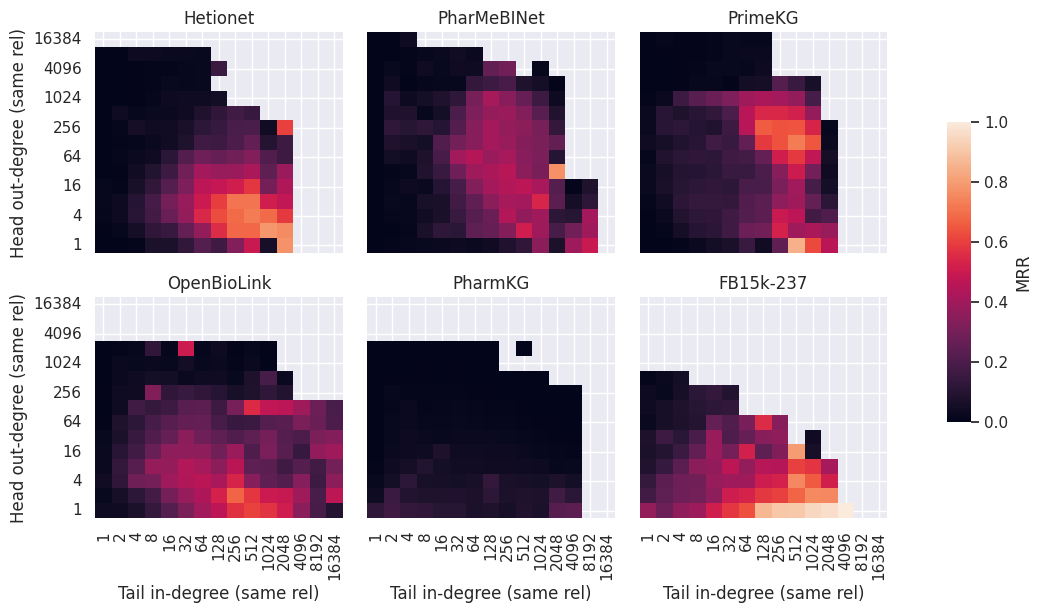

In [ ]:
# ConvE results (fig. S8)

fig, axn = plt.subplots(2, 3, figsize=[12, 6], sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.86, 0.31, 0.02, 0.5])

for n, (graph, ax) in enumerate(zip(ds_name_dir.keys(), axn.T.flat)):
    df_empty = pd.DataFrame(
        columns=np.int32(2 ** np.arange(15)), index=np.int32(2 ** np.arange(15))
    )

    df_tmp = df_mrr_cardinality[
        np.logical_and(
            df_mrr_cardinality.graph == graph,
            df_mrr_cardinality.scoring_function == "ConvE",
        )
    ][[group_metric_1, group_metric_2, perf_metric]]
    df_tmp.insert(
        0,
        f"log_{group_metric_1}",
        np.int32(
            2 ** np.floor(np.log2(df_tmp[group_metric_1].values.astype(np.float32)))
        ),
    )
    df_tmp.insert(
        0,
        f"log_{group_metric_2}",
        np.int32(
            2 ** np.floor(np.log2(df_tmp[group_metric_2].values.astype(np.float32)))
        ),
    )
    df_tmp.insert(0, value, df_tmp[perf_metric].values.astype(np.float32))
    df_tmp = (
        df_tmp.groupby([f"log_{group_metric_1}", f"log_{group_metric_2}"])
        .mean()
        .reset_index()
    )
    sns.heatmap(
        df_tmp.reset_index()
        .pivot(
            columns=f"log_{group_metric_2}",
            index=f"log_{group_metric_1}",
            values=value,
        )
        .combine_first(df_empty),
        vmin=0,
        vmax=1,
        annot=False,
        ax=ax,
        cbar=(n == 0),
        cbar_ax=None if n else cbar_ax,
        cbar_kws={"label": perf_metric},
    )
    if n % 2 == 1:
        ax.set_xlabel(name_mapping[group_metric_2])
    else:
        ax.set_xlabel("")
    if n < 2:
        ax.set_ylabel(name_mapping[group_metric_1])
    else:
        ax.set_ylabel("")
    ax.invert_yaxis()
    ax.set_title(graph)

plt.subplots_adjust(
    left=0.15,
    bottom=0.15,
    right=0.81,
    top=0.96,
    wspace=0.1,
    hspace=0.20,
)

## Effect of topological patterns on predictive performance

### Fig. 9 (and S11, S13, S14): impact of topological pattern on predictive performance

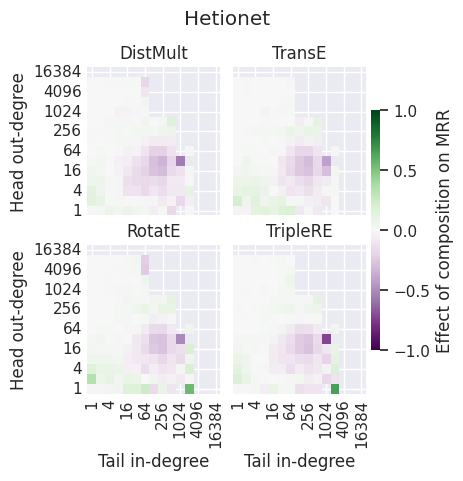

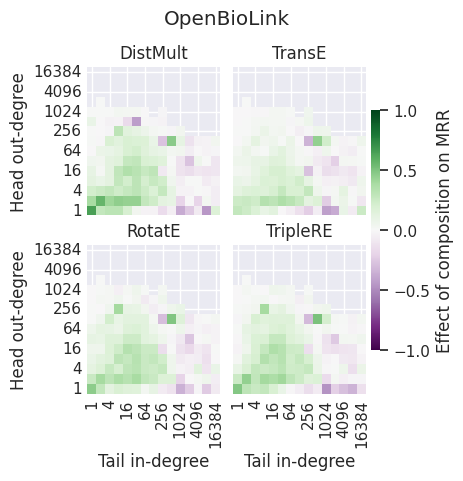

In [ ]:
metric = "has_composition"  # topological pattern to consider
metric_str = "composition"

for graph in ["Hetionet", "OpenBioLink"]:
    df_empty = pd.DataFrame(
        columns=np.int32(2 ** np.arange(15)), index=np.int32(2 ** np.arange(15))
    )

    fig, axn = plt.subplots(2, 2, figsize=[4.8, 4.8], sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.80, 0.27, 0.02, 0.5])

    for n, (value, ax) in enumerate(zip(values, axn.T.flat)):
        df_tmp = df_mrr_cardinality[
            np.logical_and(
                df_mrr_cardinality.graph == graph,
                df_mrr_cardinality.scoring_function == value,
            )
        ][[group_metric_1, group_metric_2, metric, perf_metric]]
        df_tmp.insert(
            0,
            f"log_{group_metric_1}",
            np.int32(
                2 ** np.floor(np.log2(df_tmp[group_metric_1].values.astype(np.float32)))
            ),
        )
        df_tmp.insert(
            0,
            f"log_{group_metric_2}",
            np.int32(
                2 ** np.floor(np.log2(df_tmp[group_metric_2].values.astype(np.float32)))
            ),
        )
        df_tmp.insert(0, value, df_tmp[perf_metric].values.astype(np.float32))
        df_tmp = (
            df_tmp.groupby([f"log_{group_metric_1}", f"log_{group_metric_2}", metric])
            .mean()
            .reset_index()
        )

        df_effect = pd.merge(
            df_tmp[df_tmp[metric] == True],
            df_tmp[df_tmp[metric] == False],
            on=[f"log_{group_metric_1}", f"log_{group_metric_2}"],
            suffixes=["_true", "_false"],
        )
        df_effect.insert(
            0,
            "effect",
            df_effect[f"{value}_true"] - df_effect[f"{value}_false"],
        )
        sns.heatmap(
            df_effect.reset_index()
            .pivot(
                columns=f"log_{group_metric_2}",
                index=f"log_{group_metric_1}",
                values="effect",
            )
            .combine_first(df_empty),
            vmin=-1,  # -0.4,
            vmax=1,  # 0.4,
            annot=False,
            cmap="PRGn",
            ax=ax,
            cbar=(n == 0),
            cbar_ax=None if n else cbar_ax,
            cbar_kws={
                "label": f"Effect of {metric_str} on {perf_metric}",
                "ticks": [-1, -0.5, 0, 0.5, 1],
            },
        )

        if n % 2 == 1:
            ax.set_xlabel(name_mapping[group_metric_2])
        else:
            ax.set_xlabel("")
        if n < 2:
            ax.set_ylabel(name_mapping[group_metric_1])
        else:
            ax.set_ylabel("")
        ax.invert_yaxis()
        ax.set_title(value)
        ax.tick_params(axis="both", which="major", pad=-2)

    fig.suptitle(graph)
    plt.subplots_adjust(
        left=0.21,
        bottom=0.18,
        right=0.79,
        top=0.86,
        wspace=0.1,
        hspace=0.20,
    )

### Fig. S12: results for ConvE

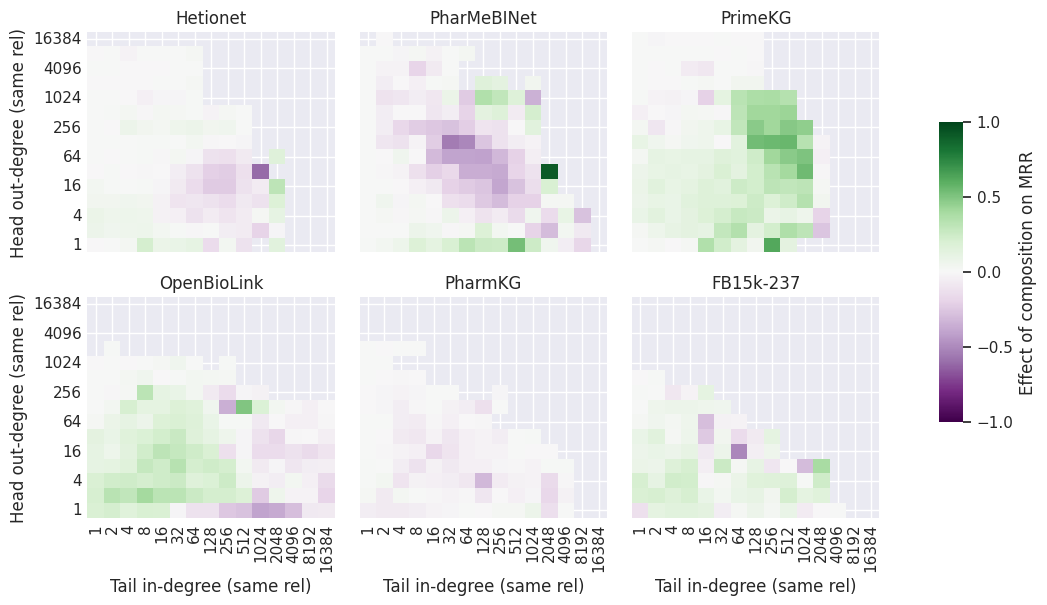

In [ ]:
# ConvE results (fig. S12)

fig, axn = plt.subplots(2, 3, figsize=[12, 6], sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.86, 0.31, 0.02, 0.5])

for n, (graph, ax) in enumerate(zip(ds_name_dir.keys(), axn.T.flat)):
    df_empty = pd.DataFrame(
        columns=np.int32(2 ** np.arange(15)), index=np.int32(2 ** np.arange(15))
    )

    df_tmp = df_mrr_cardinality[
        np.logical_and(
            df_mrr_cardinality.graph == graph,
            df_mrr_cardinality.scoring_function == "ConvE",
        )
    ][[group_metric_1, group_metric_2, metric, perf_metric]]
    df_tmp.insert(
        0,
        f"log_{group_metric_1}",
        np.int32(
            2 ** np.floor(np.log2(df_tmp[group_metric_1].values.astype(np.float32)))
        ),
    )
    df_tmp.insert(
        0,
        f"log_{group_metric_2}",
        np.int32(
            2 ** np.floor(np.log2(df_tmp[group_metric_2].values.astype(np.float32)))
        ),
    )
    df_tmp.insert(0, value, df_tmp[perf_metric].values.astype(np.float32))
    df_tmp = (
        df_tmp.groupby([f"log_{group_metric_1}", f"log_{group_metric_2}", metric])
        .mean()
        .reset_index()
    )

    df_effect = pd.merge(
        df_tmp[df_tmp[metric] == True],
        df_tmp[df_tmp[metric] == False],
        on=[f"log_{group_metric_1}", f"log_{group_metric_2}"],
        suffixes=["_true", "_false"],
    )
    df_effect.insert(
        0,
        "effect",
        df_effect[f"{value}_true"] - df_effect[f"{value}_false"],
    )
    sns.heatmap(
        df_effect.reset_index()
        .pivot(
            columns=f"log_{group_metric_2}",
            index=f"log_{group_metric_1}",
            values="effect",
        )
        .combine_first(df_empty),
        vmin=-1,  # -0.4,
        vmax=1,  # 0.4,
        annot=False,
        cmap="PRGn",
        ax=ax,
        cbar=(n == 0),
        cbar_ax=None if n else cbar_ax,
        cbar_kws={
            "label": f"Effect of {metric_str} on {perf_metric}",
            "ticks": [-1, -0.5, 0, 0.5, 1],
        },
    )

    if n % 2 == 1:
        ax.set_xlabel(name_mapping[group_metric_2])
    else:
        ax.set_xlabel("")
    if n < 2:
        ax.set_ylabel(name_mapping[group_metric_1])
    else:
        ax.set_ylabel("")
    ax.invert_yaxis()
    ax.set_title(graph)
    ax.tick_params(axis="both", which="major", pad=-2)

plt.subplots_adjust(
    left=0.15,
    bottom=0.15,
    right=0.81,
    top=0.96,
    wspace=0.1,
    hspace=0.20,
)

## Fig. S4: frequency of patterns vs predictive performance across datasets

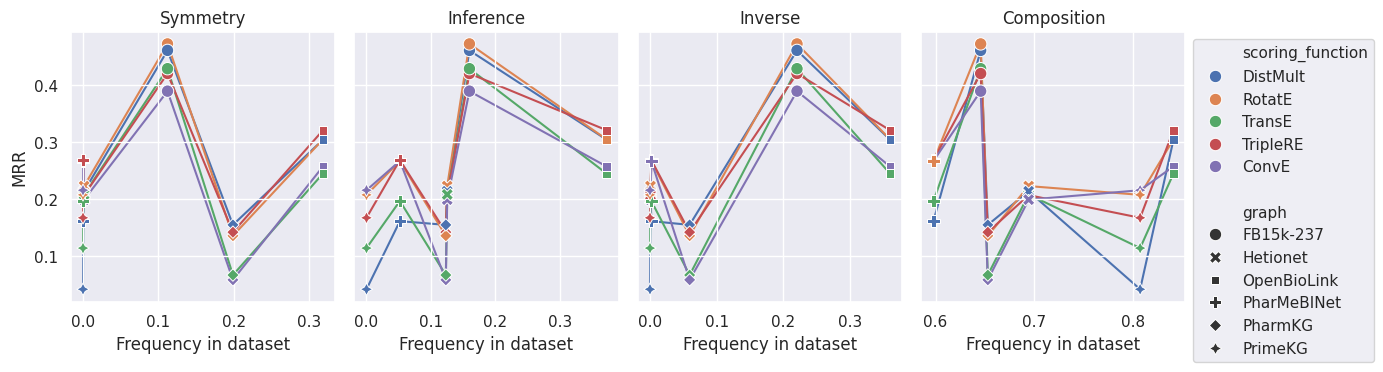

In [ ]:
fig, axn = plt.subplots(1, 4, figsize=[14, 3.8], sharey=True)
pattern = {
    "is_loop": "Loop",
    "is_symmetric": "Symmetry",
    "has_inverse": "Inverse",
    "has_inference": "Inference",
    "has_composition": "Composition",
}
# pattern = {"1:1": "1:1", "1:M": "1:M", "M:1": "M:1", "M:M": "M:M"}

for n, (metric, ax) in enumerate(
    zip(
        ["is_symmetric", "has_inference", "has_inverse", "has_composition"],
        # pattern.keys(),
        axn.flatten(),
    )
):
    df_tmp = df_mrr_cardinality[
        ["graph", metric, "scoring_function", perf_metric]
    ].copy()
    df_tmp[metric] = df_tmp.groupby(["graph", "scoring_function"])[metric].transform(
        "mean"
    )
    df_tmp = (
        df_tmp.groupby([metric, "scoring_function", "graph"])
        .agg({perf_metric: "mean"})
        .reset_index()
        .sort_values("graph")
    )
    sns.lineplot(
        df_tmp,
        x=metric,
        y=perf_metric,
        hue="scoring_function",
        hue_order=values,
        legend=False,
        ax=ax,
        zorder=0,
    )
    scatter_plot = sns.scatterplot(
        df_tmp,
        x=metric,
        y=perf_metric,
        hue="scoring_function",
        hue_order=values,
        style="graph",
        s=80,
        ax=ax,
        zorder=1,
    )
    ax.set_xlabel("Frequency in dataset")
    # ax.set_xlim(0,1)
    if n == 3:
        # Extract handles and labels for hue and style separately and add a line in-between in the legend
        handles, labels = ax.get_legend_handles_labels()
        hue_handles = handles[: len(df_tmp["scoring_function"].unique()) + 1]
        hue_labels = labels[: len(df_tmp["scoring_function"].unique()) + 1]
        style_handles = handles[len(df_tmp["scoring_function"].unique()) + 1 :]
        style_labels = labels[len(df_tmp["scoring_function"].unique()) + 1 :]
        scatter_plot.legend(
            handles=hue_handles + [plt.Line2D([0], [0], color="none")] + style_handles,
            labels=hue_labels + [""] + style_labels,
            bbox_to_anchor=(1, 1),
            loc="upper left",
        )
    else:
        ax.get_legend().remove()
    ax.set_title(pattern[metric])

plt.tight_layout()

## Fig. S5: correlations between topological patterns (grouped by relation type)  and predictive performance across datasets

/tmp/ipykernel_134796/2998259024.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_corr = pd.concat([all_corr, corr], ignore_index=True)


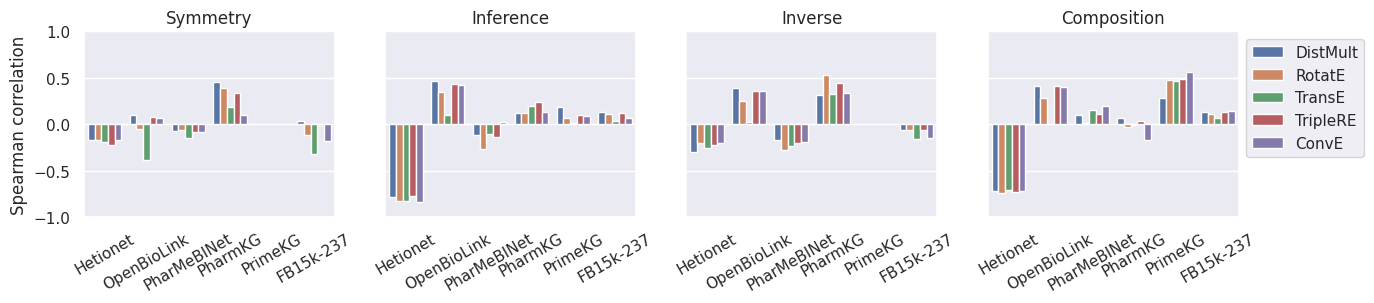

In [ ]:
all_corr = pd.DataFrame(
    columns=[
        "Graph",
        "Scoring Function",
        "is_symmetric",
        "has_inverse",
        "has_inference",
        "has_composition",
    ]
)

for graph in ds_name_dir.keys():
    df_mrr_rel = (
        kge_ranks[graph].groupby("r").agg({m: lambda x: np.mean(1 / x) for m in values})
    )

    df_metrics = (
        eps_dict[graph]
        .groupby("r")[
            [
                "is_symmetric",
                "has_inverse",
                "has_inference",
                "has_composition",
            ]
        ]
        .mean()
    )

    df_mrr_rel = df_mrr_rel.merge(df_metrics, on="r")
    corr = (
        df_mrr_rel.corr(method="spearman")
        .iloc[: len(values), len(values) :]
        .reset_index()
        .rename(columns={"index": "Scoring Function"})
    )
    corr.insert(0, "Graph", graph)
    all_corr = pd.concat([all_corr, corr], ignore_index=True)

fig, axn = plt.subplots(1, 4, figsize=[14, 3.2], sharey=True)
pattern = {
    "is_loop": "Loop",
    "is_symmetric": "Symmetry",
    "has_inverse": "Inverse",
    "has_inference": "Inference",
    "has_composition": "Composition",
}

for n, (metric, ax) in enumerate(
    zip(
        ["is_symmetric", "has_inference", "has_inverse", "has_composition"],
        axn.flatten(),
    )
):
    sns.barplot(all_corr, x="Graph", y=metric, hue="Scoring Function", ax=ax)
    ax.set_ylabel(pattern[metric])
    ax.set_xlabel("")
    ax.set_ylim(-1, 1)
    if n == 3:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()
    ax.set_ylabel("Spearman correlation")
    ax.set_title(pattern[metric])
    ax.tick_params(axis="x", labelrotation=30)

plt.tight_layout()

## Fig. S6: correlations between edge cardinality (grouped by relation type) and predictive performance across datasets

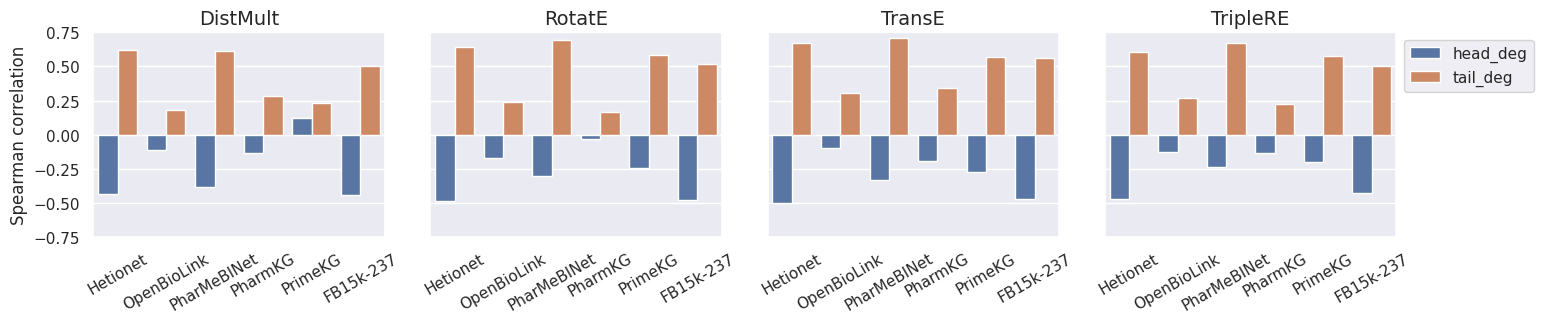

In [ ]:
fig, axn = plt.subplots(1, 4, figsize=(3.1 * 5, 3.4), sharey=True)
for i, (sc, ax) in enumerate(zip(values, axn.flat)):
    correlations = []
    for graph in ds_name_dir.keys():
        dataf = df_mrr_cardinality[
            np.logical_and(
                df_mrr_cardinality.graph == graph,
                df_mrr_cardinality.scoring_function == sc,
            )
        ]
        correlations.append(
            [
                graph,
                scipy.stats.spearmanr(dataf[["h_degree_same_rel", perf_metric]])[0],
                "head_deg",
            ]
        )
        correlations.append(
            [
                graph,
                scipy.stats.spearmanr(dataf[["t_degree_same_rel", perf_metric]])[0],
                "tail_deg",
            ]
        )
    df_to_plot = pd.DataFrame(
        correlations, columns=["graph", "correlation", "degree_type"]
    )
    sns.barplot(df_to_plot, x="graph", y="correlation", hue="degree_type", ax=ax)
    ax.set_title(sc, fontsize=14)
    ax.set_xlabel("")
    if i == 3:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()
    ax.set_ylim(-0.75, 0.75)
    ax.set_ylabel("Spearman correlation")
    ax.tick_params(axis="x", labelrotation=30)
fig.tight_layout()

## Analysis of selected relation types

In [5]:
# Numerical IDs of selected relations

drug_disease_rels = {
    "Hetionet": [6, 8],
    "OpenBioLink": [],
    "PharMeBINet": [53, 105, 178, 198],
    "PharmKG": [25, 3, 17],
    "PrimeKG": [8, 5],
}
disease_gene_rels = {
    "Hetionet": [10, 11, 15],
    "OpenBioLink": [],
    "PharMeBINet": [27, 70, 205],
    "PharmKG": [],
    "PrimeKG": [18],
}
gene_gene_rels = {
    "Hetionet": [16, 17, 22],
    "OpenBioLink": [4],
    "PharMeBINet": [57, 108, 194],
    "PharmKG": [15, 35],
    "PrimeKG": [0],
}
drug_gene_rels = {
    "Hetionet": [3, 5, 9],
    "OpenBioLink": [6, 21],
    "PharMeBINet": [23, 44, 68, 203],
    "PharmKG": [7, 9, 4, 29],
    "PrimeKG": [15],
}

### Fig. S15b: frequency of topological patterns in the selected relation types

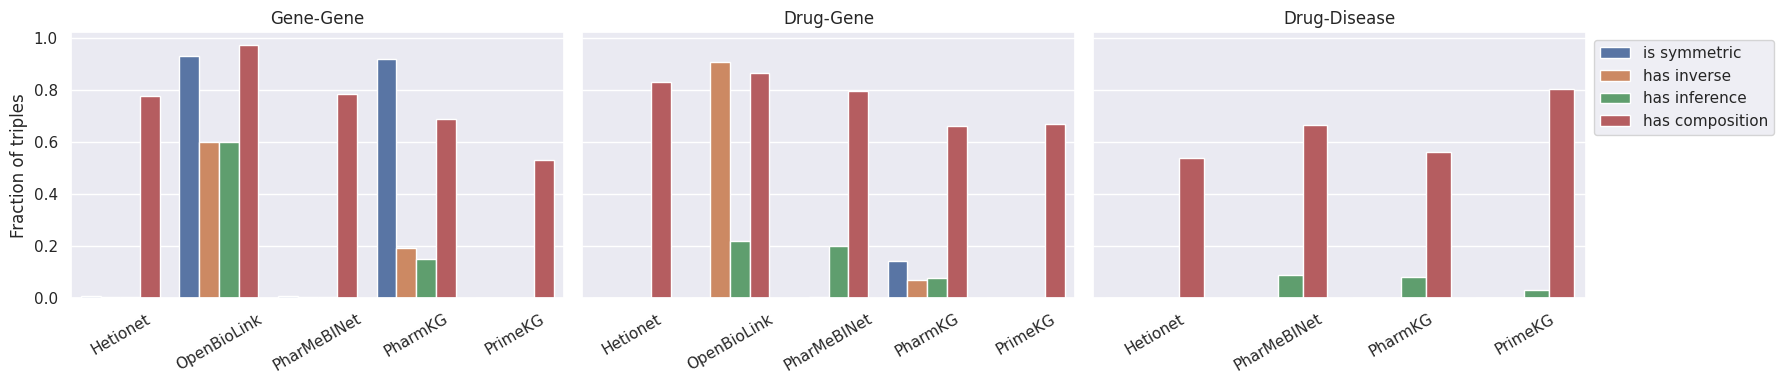

In [ ]:
rel_to_plot = {
    "Gene-Gene": gene_gene_rels,
    "Drug-Gene": drug_gene_rels,
    "Drug-Disease": drug_disease_rels,
}

fig, axn = plt.subplots(
    1, len(rel_to_plot), figsize=[6 * len(rel_to_plot), 4], sharey=True
)


for i, (name_rel, ax) in enumerate(zip(rel_to_plot.keys(), axn.flat)):
    exp_list = []
    for ds_name, ds_rels in rel_to_plot[name_rel].items():
        eps = eps_dict[ds_name][eps_dict[ds_name].r.isin(ds_rels)]
        exp_list.append(
            pd.DataFrame(
                {
                    "data": eps["is_symmetric"].mean(),
                    "type": "is symmetric",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
        exp_list.append(
            pd.DataFrame(
                {
                    "data": eps["has_inverse"].mean(),
                    "type": "has inverse",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
        exp_list.append(
            pd.DataFrame(
                {
                    "data": eps["has_inference"].mean(),
                    "type": "has inference",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
        exp_list.append(
            pd.DataFrame(
                {
                    "data": eps["has_composition"].mean(),
                    "type": "has composition",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
    all_exp_res = pd.concat(exp_list).dropna()

    sns.barplot(
        all_exp_res,
        x="dataset",
        y="data",
        hue="type",
        ax=ax,
    )
    if i < len(axn.flat) - 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.tick_params(axis="x", labelrotation=30)
    ax.set_xlabel("")
    ax.set_ylabel("Fraction of triples")
    ax.set_title(name_rel)
    plt.tight_layout()

### Fig. S15a: median edge cardinalities (and number of unique tails) in the selected relation types

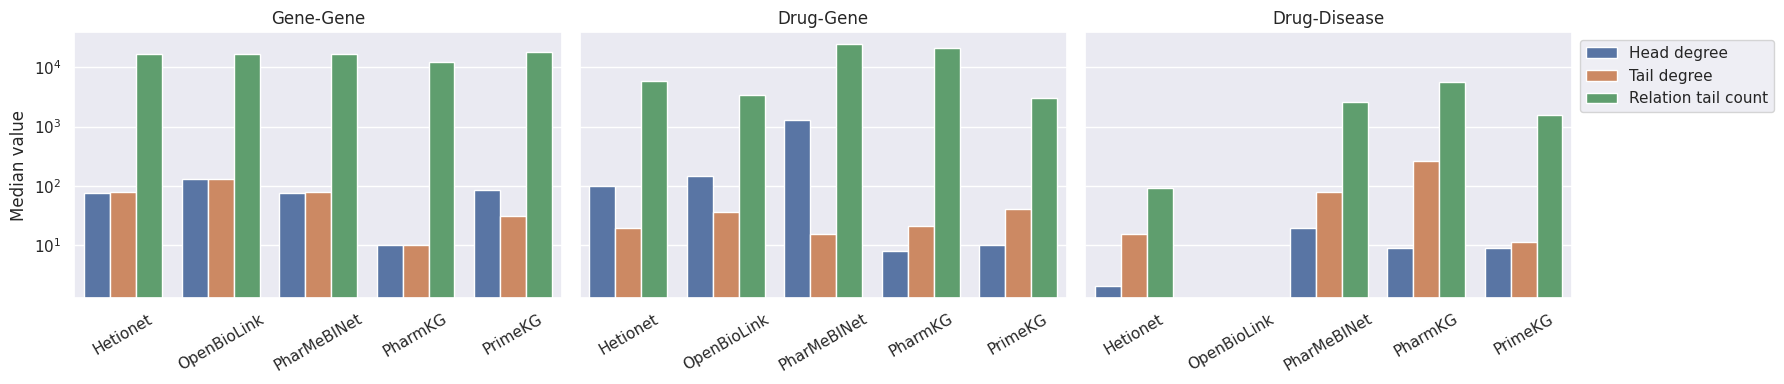

In [ ]:
# Fig. S15a

fig, axn = plt.subplots(
    1, len(rel_to_plot), figsize=[6 * len(rel_to_plot), 4], sharey=True
)


for i, (name_rel, ax) in enumerate(zip(rel_to_plot.keys(), axn.flat)):
    exp_list = []
    for ds_name, ds_rels in rel_to_plot[name_rel].items():
        dcs = dcs_dict[ds_name][dcs_dict[ds_name].r.isin(ds_rels)]
        n_t_candidates = dcs.t.unique().shape[0]

        exp_list.append(
            pd.DataFrame(
                {
                    "data": dcs["h_degree_same_rel"].median(),
                    "type": "Head degree",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
        exp_list.append(
            pd.DataFrame(
                {
                    "data": dcs["t_degree_same_rel"].median(),
                    "type": "Tail degree",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
        exp_list.append(
            pd.DataFrame(
                {
                    "data": n_t_candidates,
                    "type": "Relation tail count",
                    "dataset": ds_name,
                },
                index=[0],
            )
        )
    all_exp_res = pd.concat(exp_list).dropna()

    sns.barplot(
        all_exp_res,
        x="dataset",
        y="data",
        hue="type",
        ax=ax,
    )
    if i < len(axn.flat) - 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.tick_params(axis="x", labelrotation=30)
    ax.set_xlabel("")
    ax.set_ylabel("Median value")
    ax.set_title(name_rel)
    ax.set(yscale="log")
    plt.tight_layout()

### Fig. 10 (and S17): predictive performance on the selected relation types

/tmp/ipykernel_10255/4024426021.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df["exp"] = exp_name
/tmp/ipykernel_10255/4024426021.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df["exp"] = exp_name
/tmp/ipykernel_10255/4024426021.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

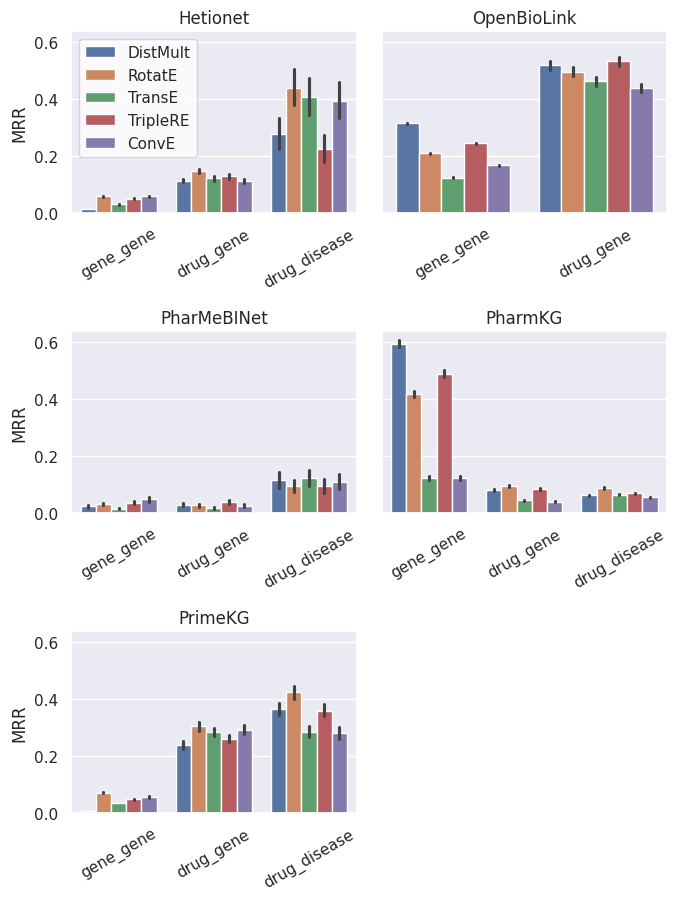

In [ ]:
# Fig. 10 (and S17)

rel_class = {
    "gene_gene": gene_gene_rels,
    "drug_gene": drug_gene_rels,
    "drug_disease": drug_disease_rels,
}

fig, ax = plt.subplots(3, 2, figsize=[3.5 * 2, 3.06 * 3], sharey=True)
ax[-1, -1].axis("off")

for i, (name_ds, axn) in enumerate(zip(ds_name_dir.keys(), ax.flat)):
    if name_ds == "FB15k-237":
        continue
    exp_list = []
    for exp_name, exp_rels in rel_class.items():
        if name_ds not in exp_rels.keys():
            continue
        exp_df = df_mrr_cardinality.query(
            f"graph == '{name_ds}' and r in {exp_rels[name_ds]}"
        )
        exp_df["exp"] = exp_name
        exp_list.append(exp_df)
    all_exp_res = pd.concat(exp_list)

    sns.barplot(
        all_exp_res,
        x="exp",
        y=perf_metric,
        hue="scoring_function",
        ax=axn,
        hue_order=values,
    )
    if i != 0:
        axn.get_legend().remove()
    else:
        axn.legend(loc="upper left", facecolor="white")
    axn.tick_params(axis="x", labelrotation=30)
    axn.set_xlabel("")
    axn.set_ylabel(perf_metric)
    axn.set_title(name_ds)
plt.tight_layout()

## Demixing analysis

In [ ]:
# Load IDs of top-100 tails, as predicted by models
# (download from https://zenodo.org/records/12097377/files/top_100_tail_predictions.zip)

pred_ids = {
    graph: dict(np.load(f"../datasets/{graph}/top100_preds.npz"))
    for graph in ds_name_dir.keys()
}

In [ ]:
# ID of entities in KG of relevant types

primekg_type_ids = pickle.load(
    open(
        "../datasets/data/primekg/type_ids.pkl",
        "rb",
    )
)
primekg_ent_type, primekg_type_id = np.unique(primekg_type_ids, return_inverse=True)

range_drug = {
    "Hetionet": (13172, 14710),
    "PharMeBINet": (34954, 61780),
    "PrimeKG": np.where(primekg_type_id == 4)[0],
    "OpenBioLink": (0, 1),
    "PharmKG": (0, 139120),
}
range_gene_prot = {
    "Hetionet": (14846, 33991),
    "PharMeBINet": (265318, 1660035),
    "PrimeKG": np.where(primekg_type_id == 7)[0],
    "OpenBioLink": (0, 1),
    "PharmKG": (144395, 188296),
}
range_dis = {
    "Hetionet": (14710, 14846),
    "PharMeBINet": (200719, 222936),
    "PrimeKG": np.where(primekg_type_id == 3)[0],
    "OpenBioLink": (0, 1),
    "PharmKG": (139120, 144395),
}

### Fig. S16: demixing capabilities of KGE models for the selected relation types

/tmp/ipykernel_150133/2377585439.py:14: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(preds.flatten(), tail_set).reshape(preds.shape).sum(-1)


Hetionet 91 (715,)


/tmp/ipykernel_150133/2377585439.py:14: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(preds.flatten(), tail_set).reshape(preds.shape).sum(-1)


PharMeBINet 2601 (1540,)


/tmp/ipykernel_150133/2377585439.py:14: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(preds.flatten(), tail_set).reshape(preds.shape).sum(-1)


PharmKG 5685 (117415,)


/tmp/ipykernel_150133/2377585439.py:14: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(preds.flatten(), tail_set).reshape(preds.shape).sum(-1)


PrimeKG 1548 (5975,)


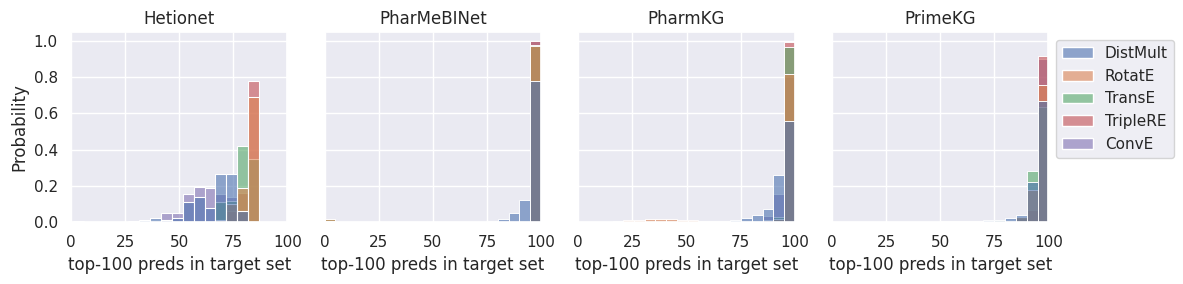

In [ ]:
rel_to_plot = drug_disease_rels

perc_dfs = []
for ds in rel_to_plot.keys():
    if rel_to_plot[ds] == []:
        continue

    res_graph = df_mrr_cardinality.query(f"graph == '{ds}'").reset_index()
    assert len(res_graph) / len(values) == len(pred_ids[ds]["TransE"])
    res = res_graph.query(f"r in  r in {rel_to_plot[ds]}")
    tail_set = dcs_dict[ds].query(f"r in  r in {rel_to_plot[ds]}").t.unique()
    preds = np.concat([pred_ids[ds][v] for v in values])[res.index]
    right_type_perc = (
        np.in1d(preds.flatten(), tail_set).reshape(preds.shape).sum(-1)
        / preds.shape[-1]
    )

    perc_dfs.append(
        pd.DataFrame(
            {
                "right_perc": 100 * right_type_perc,
                "scoring": res.scoring_function,
                "dataset": ds,
            }
        )
    )
    print(ds, tail_set.shape[0], right_type_perc.shape)

perc_df = pd.concat(perc_dfs, axis=0)

ds_to_plot = [k for k, v in rel_to_plot.items() if v != []]
fig, axn = plt.subplots(
    1, len(ds_to_plot), figsize=[3 * len(ds_to_plot), 3], sharey=True
)

for i, (dts, ax) in enumerate(zip(ds_to_plot, axn.flat)):
    to_plot = perc_df[perc_df["dataset"] == dts]
    sns.histplot(
        data=to_plot,
        x="right_perc",
        stat="probability",
        ax=ax,
        hue="scoring",
        common_norm=False,
        hue_order=values,
        binwidth=5,
        alpha=0.6,
    )
    if i < len(axn.flat) - 1:
        ax.get_legend().remove()
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        ax.legend_.set_title(None)

    ax.set_xlabel("top-100 preds in target set")
    ax.set_title(f"{dts}")
    ax.set_xlim(left=0, right=100)
plt.tight_layout()